In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import time
import matplotlib.dates as mdates
%matplotlib notebook
%matplotlib inline
#plt.style.use('seaborn')
sns.set_palette("muted")

In [2]:
filePath = 'data/july-2017-thru-june-2018.txt'

In [3]:
accre_data = pd.read_csv(filePath, delimiter='|')

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Restrict data to just jobs submitted to the production queue

In [4]:
accre_data = accre_data.loc[accre_data.Partition == 'production']

### Recast date/time columns as datetime format

In [5]:
accre_data.Submit = pd.to_datetime(accre_data.Submit)
accre_data.Start = pd.to_datetime(accre_data.Start)

### Calculate WaitTime and assign to new column

In [6]:
accre_data['WaitTime'] = accre_data.Start - accre_data.Submit

### Temporarily subset data

In [7]:
#idx = np.random.randint(0,len(accre_data),5000)
#accre_data = accre_data.iloc[idx]

### Strip off the last two characters of ReqMem and pass to new columns

In [8]:
accre_data['NorC'] = accre_data.ReqMem.str[-1]
accre_data['MemUnits'] = accre_data.ReqMem.str[-2]
accre_data['ReqMemInBytes'] = accre_data.ReqMem.str[:-2]
accre_data['ReqMemInBytes'] = pd.to_numeric(accre_data.ReqMemInBytes, errors='ignore')
accre_data.MemUnits.value_counts()

M    7866493
G    4434926
Name: MemUnits, dtype: int64

In [9]:
accre_data.NNodes = pd.to_numeric(accre_data.NNodes, errors = 'ignore')
accre_data.NCPUS = pd.to_numeric(accre_data.NCPUS, errors = 'ignore')

### Convert ReqMem to useable units (bytes)

In [10]:
print(accre_data.ReqMemInBytes.head(),accre_data.ReqMem.head())

mask = (accre_data.NorC == 'n')
accre_data.loc[mask,'ReqMemInBytes'] = accre_data.loc[mask,'ReqMemInBytes']*accre_data.loc[mask,'NNodes']
accre_data.loc[~mask,'ReqMemInBytes'] = accre_data.loc[~mask,'ReqMemInBytes']*accre_data.loc[~mask,'NCPUS']
#maskT = (accre_data.MemUnits == 'T')
#accre_data.loc[maskT,'ReqMemInBytes'] = accre_data.loc[maskT,'ReqMemInBytes']*(10.**12.)
maskG = (accre_data.MemUnits == 'G')
accre_data.loc[maskG,'ReqMemInBytes'] = accre_data.loc[maskG,'ReqMemInBytes']*(10.**9.)
maskM = (accre_data.MemUnits == 'M')
accre_data.loc[maskM,'ReqMemInBytes'] = accre_data.loc[maskM,'ReqMemInBytes']*(10.**6.)
#maskk = (accre_data.MemUnits == 'k')
#accre_data.loc[maskk,'ReqMemInBytes'] = accre_data.loc[maskk,'ReqMemInBytes']*(10.**3.)

print(accre_data.ReqMemInBytes.head(),accre_data.ReqMem.head())

0      12.0
1      12.0
2      12.0
3      12.0
4    4000.0
Name: ReqMemInBytes, dtype: float64 0      12Gn
1      12Gn
2      12Gn
3      12Gn
4    4000Mn
Name: ReqMem, dtype: object
0    1.200000e+10
1    1.200000e+10
2    1.200000e+10
3    1.200000e+10
4    4.000000e+09
Name: ReqMemInBytes, dtype: float64 0      12Gn
1      12Gn
2      12Gn
3      12Gn
4    4000Mn
Name: ReqMem, dtype: object


### Reformat the Timelimit series

In [11]:
accre_data['ReqD'] = pd.to_numeric(accre_data.Timelimit.str[:-9]).fillna(value=0)*24. # in units of hours
accre_data['ReqHMS'] = pd.to_timedelta(accre_data.Timelimit.str[-7::]).astype('timedelta64[s]')/(3600.) # in units of hours
print(accre_data.Timelimit.head(),accre_data.ReqD.head(),accre_data.ReqHMS.head())

0    9-04:00:00
1    9-04:00:00
2    9-04:00:00
3    9-04:00:00
4    2-00:00:00
Name: Timelimit, dtype: object 0    216.0
1    216.0
2    216.0
3    216.0
4     48.0
Name: ReqD, dtype: float64 0    4.0
1    4.0
2    4.0
3    4.0
4    0.0
Name: ReqHMS, dtype: float64


In [12]:
accre_data.WaitTime.astype('timedelta64[s]').head()

0    91981.0
1    92350.0
2    93615.0
3    94255.0
4        1.0
Name: WaitTime, dtype: float64

### Is there a relationship between the amount of computing time requested by a user and the queue time?

[]

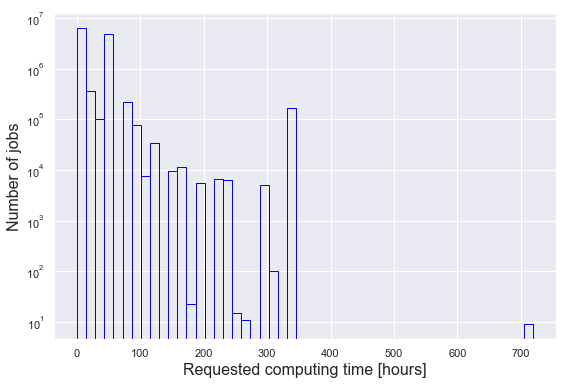

In [17]:
plt.figure(figsize=(9,6))
plt.hist(accre_data.ReqD+accre_data.ReqHMS,bins=50,histtype='bar',fill=False,edgecolor='blue')
plt.xlabel('Requested computing time [hours]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hours]')

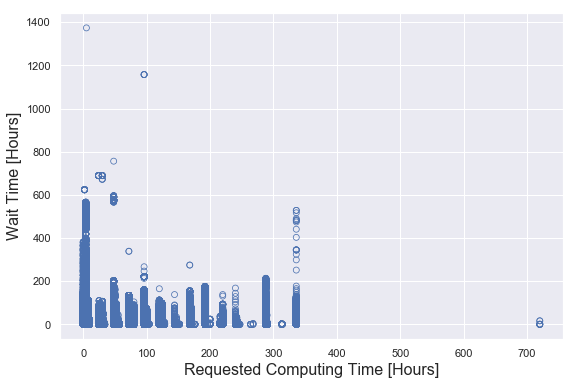

In [31]:
plt.figure(figsize=(9,6))
sns.scatterplot(x=accre_data.ReqD+accre_data.ReqHMS,y=accre_data.WaitTime.astype('timedelta64[s]')/3600.,palette='muted',edgecolor='b',facecolor='None')
#plt.semilogx()
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

Text(0,0.5,'Wait Time [Hours]')

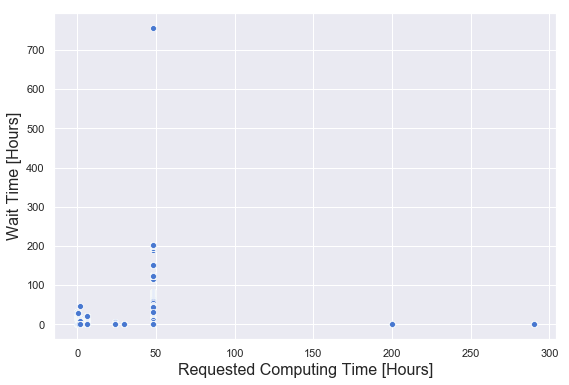

In [15]:
plt.figure(figsize=(9,6))
subset = accre_data.loc[accre_data.Group=='cms']
sns.scatterplot(x=subset.ReqD+subset.ReqHMS,y=subset.WaitTime.astype('timedelta64[s]')/3600.)
#plt.semilogy()
plt.xlabel('Requested Computing Time [Hours]',fontsize=16)
plt.ylabel('Wait Time [Hours]',fontsize=16)

## Does a relationship exist between the amount of memory requested by a user and their wait time in the queue?

[]

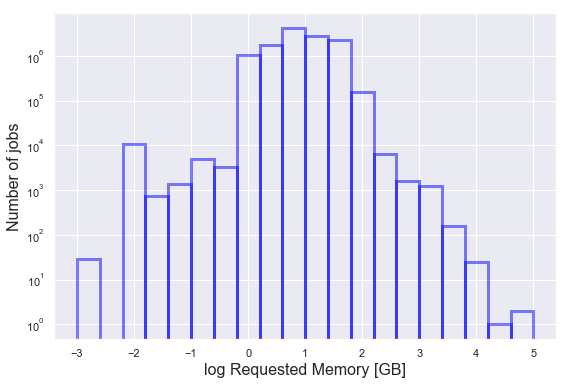

In [29]:
plt.figure(figsize=(9,6))
sns.distplot(np.log10(accre_data.ReqMemInBytes.dropna()/(10.**9)), kde=False, bins=20, hist_kws={"histtype": "bar", "linewidth": 3,"alpha": 0.5, "edgecolor": "blue", "facecolor": "None"})
plt.xlabel('log Requested Memory [GB]',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

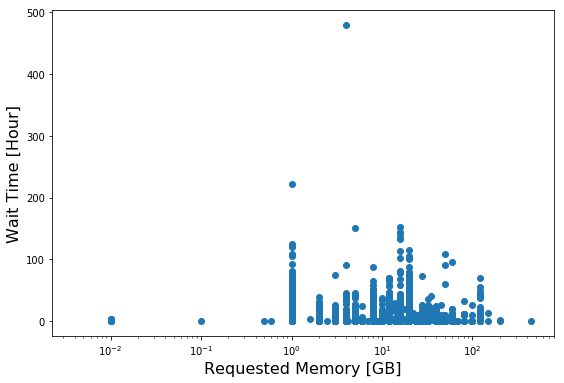

In [29]:
plt.figure(figsize=(9,6))
plt.scatter(accre_data.ReqMemInBytes/(10.**9.),accre_data.WaitTime.astype('timedelta64[s]')/3600.,'.')
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

### Let's look at a single group, which all have the same fair-share rank.  The CMS group submits the most jobs.

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

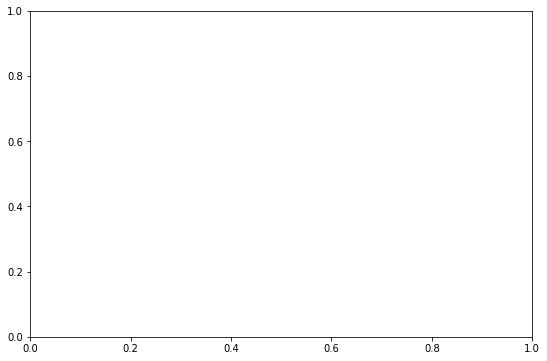

In [72]:
plt.figure(figsize=(9,6))
subset = accre_data.loc[accre_data.Group=='cms']
plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
plt.xlabel('Requested Memory [GB]',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

### Let's subset this further by looking at a time when the queue is busy.

In [202]:
#subset.sort_values('Submit', inplace=True)
#subset = subset.groupby('User').rolling('14400s', on='Submit').JobIDRaw.count()
#subset.head()

In [203]:
#subset = accre_data.loc[accre_data.NCPUS == 1]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 1$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [204]:
#subset = accre_data.loc[accre_data.NCPUS == 2]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 2$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [205]:
#subset = accre_data.loc[accre_data.NCPUS == 8]
#plt.scatter(subset.ReqMemInBytes/(10.**9.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} = 8$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [GB]')
#plt.ylabel('Wait Time [Hour]')

In [206]:
#subset = accre_data.loc[accre_data.NCPUS > 8]
#plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm CPUs} > 8$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [MB]')
#plt.ylabel('Wait Time [Hour]')

In [207]:
#subset = accre_data.loc[accre_data.NNodes > 1]
#plt.scatter(subset.ReqMemInBytes/(10.**6.),subset.WaitTime.astype('timedelta64[s]')/3600.,label=r'$N_{\rm nodes} > 1$')
#plt.semilogx()
#plt.semilogy()
#plt.legend()
##plt.ylim(0.1,1000.)
#plt.xlabel('Requested Memory [MB]')
#plt.ylabel('Wait Time [Hour]')

## Does a relationship exist between the number of CPUs requested by a user and their wait time in the queue?

[]

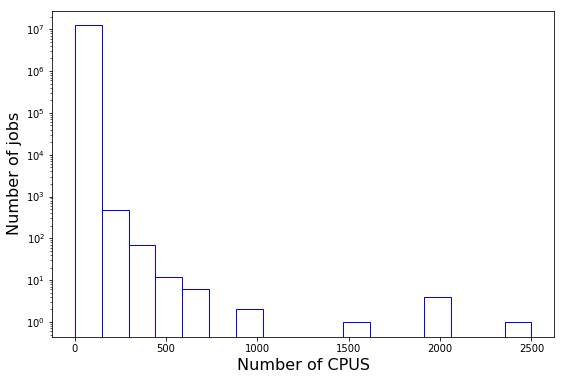

In [69]:
plt.figure(figsize=(9,6))
plt.hist(accre_data.NCPUS,bins=17,histtype='bar',fill=False,edgecolor='blue')
plt.xlabel('Number of CPUS',fontsize=16)
plt.ylabel('Number of jobs',fontsize=16)
plt.semilogy()

Text(0,0.5,'Wait Time [Hour]')

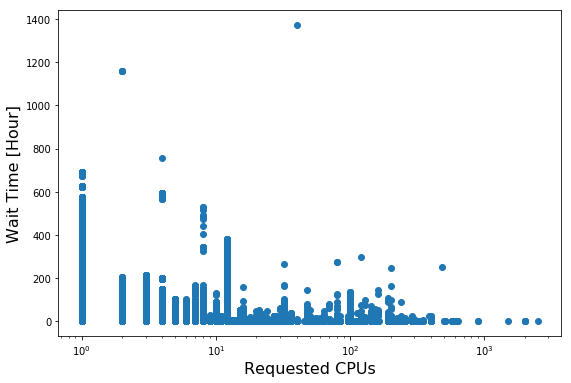

In [68]:
plt.figure(figsize=(9,6))
#print(accre_data.WaitTime)
#accre_data.WaitTime = pd.to_numeric(accre_data.WaitTime)
#print(accre_data.WaitTime)
plt.scatter(accre_data.NCPUS,accre_data.WaitTime.astype('timedelta64[s]')/3600.)
plt.semilogx()
#sns.kdeplot(accre_data.NCPUS,accre_data.WaitTime.astype('timedelta64[s]')/3600.)
#plt.semilogy()
#plt.legend()
#plt.ylim(0.1,1000.)
plt.xlabel('Requested CPUs',fontsize=16)
plt.ylabel('Wait Time [Hour]',fontsize=16)

In [210]:
#subset = accre_data.loc[(accre_data.NCPUS <= 4) & (accre_data.ReqMemInBytes <= 10.**10.)]
#plt.hist2d(subset.ReqMemInBytes/(10.**9.),subset.NCPUS)

In [ ]:
threeD = plt.figure(figsize=(9,6)).gca(projection='3d')
threeD.scatter(subset.WaitTime.astype('timedelta64[s]')/3600., subset.ReqMemInBytes/(10.**9.), subset.NCPUS)
threeD.set_xlabel('Wait Time [hours]')
threeD.set_ylabel('Requested Memory [GB]')
threeD.set_zlabel('NCPUs')
plt.show()

## Common lore in my department is that your jobs will experience a shorter queue time if you submit them at 3 AM.  Is this true?  Is there a relationship between the time of day of job submission and wait time in the queue?

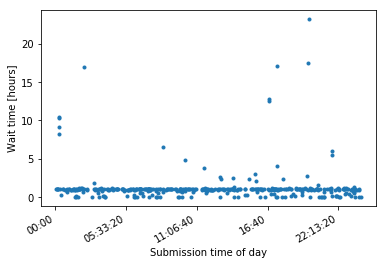

In [81]:
plt.figure(figsize=(9,6))
#subset = subset.loc[(accre_data.NCPUS == 1) & (accre_data.ReqMemInBytes == 10.**10.)]
#hours = mdates.HourLocator(interval = 6)
#h_fmt = mdates.DateFormatter('%H:%M:%S')
fig,ax = plt.subplots()
ax.plot(subset.Submit.dt.time,subset.WaitTime.astype('timedelta64[s]')/3600.,'.')
ax.set_ylabel('Wait time [hours]')
ax.set_xlabel('Submission time of day')
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate(rotation=30)

In [82]:
accre_data.index = accre_data['Submit']
accre_data.loc[:,'Njobs'] = 1 # dummy series for counting jobs
accre_data_resampled = accre_data.resample('H').sum()
accre_data_resampled.loc[accre_data_resampled.Njobs == accre_data_resampled.Njobs.max()]

,JobIDRaw,GID,UID,NNodes,NCPUS,ReqCPUS,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,
2017-09-15 02:00:00,400789498,1307240,12632444.0,22,22,22,2.110240e+11,0.0,42.166667,22


### Let's look at jobs submitted between 02:00:00 and 03:00:00 on 2017-09-15

In [188]:
mask = (accre_data.Submit >= '2017-09-15 02:00:00') & (accre_data.Submit < '2017-09-15 03:00:00')
subset = accre_data.loc[mask]
subset

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName,WaitTime,NorC,MemUnits,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-15 02:15:48,18130480_380,18153203,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:15:48,2017-09-15T02:26:04,2017-09-15 02:31:54,2017-09-15 02:32:00,00:00:06,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1379,02308,00:16:06,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:03:32,18115092_2649,18210397,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:03:32,2017-09-15T03:09:55,2017-09-15 03:09:56,2017-09-15 03:10:02,00:00:06,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1368,00711,01:06:24,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:15:48,18130480_803,18171573,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:15:48,2017-09-15T02:44:32,2017-09-15 02:44:33,2017-09-15 02:44:39,00:00:06,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp416,02308,00:28:45,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:29:45,18150089_202,18159596,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:29:45,2017-09-15T02:29:46,2017-09-15 02:36:08,2017-09-15 02:36:42,00:00:34,0:0,COMPLETED,1,1,1,2Gn,NaN,"cpu=1,mem=2G,node=1",00:30:00,vmp1379,02106,00:06:23,n,G,2.000000e+09,0.0,0.500000,1
2017-09-15 02:20:38,18137181_7,18140591,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:20:38,2017-09-15T02:20:39,2017-09-15 02:23:03,2017-09-15 02:23:06,00:00:03,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1316,00461,00:02:25,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:24:43,18142825_709,18199747,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:24:43,2017-09-15T03:03:11,2017-09-15 03:03:11,2017-09-15 03:03:13,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1099,00647,00:38:28,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:03:34,18115111_719,18145825,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:03:34,2017-09-15T02:26:47,2017-09-15 02:26:47,2017-09-15 02:26:56,00:00:09,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp233,00705,00:23:13,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:03:31,18115081_2714,18207450,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:03:31,2017-09-15T03:08:07,2017-09-15 03:08:07,2017-09-15 03:08:12,00:00:05,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1113,00534,01:04:36,n,G,1.000000e+10,0.0,2.000000,1
2017-09-15 02:03:35,18115186_3183,18272289,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-15 02:03:35,2017-09-15T03:48:29,2017-09-15 03:48:29,2017-09-15 03:48:32,00:00:03,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp231,00128,01:44:54,n,G,1.000000e+10,0.0,2.000000,1


### We have stumbled upon a problem user... 'sotcos' submitted NNN jobs in one hour that all ran for less than a minute.  Let's look at the second busiest hour.

In [165]:
accre_data_resampled.loc[accre_data_resampled.Njobs == accre_data_resampled.Njobs.nlargest(5)[1]]

,JobIDRaw,GID,UID,NNodes,NCPUS,ReqCPUS,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,
2017-09-16 13:00:00,1248710902,3981140,38471534.0,67,67,67,6.700000e+11,0.0,134.0,67


In [166]:
mask = (accre_data.Submit >= '2017-09-16 13:00:00') & (accre_data.Submit < '2017-09-16 14:00:00')
subset = accre_data.loc[mask]
subset

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName,WaitTime,NorC,MemUnits,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-16 13:14:44,18560237_750,18564672,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:14:44,2017-09-16T13:21:38,2017-09-16 13:21:39,2017-09-16 13:21:41,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp464,00002,00:06:55,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:12:15,18558837_11150,18641523,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:12:15,2017-09-16T15:02:00,2017-09-16 15:02:01,2017-09-16 15:02:02,00:00:01,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1348,00003,01:49:46,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:11:12,18558214_67,18558351,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:11:12,2017-09-16T13:11:22,2017-09-16 13:11:23,2017-09-16 13:11:25,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1258,00011,00:00:11,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:11:12,18558214_1878,18567278,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:11:12,2017-09-16T13:25:22,2017-09-16 13:25:23,2017-09-16 13:25:24,00:00:01,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp320,00011,00:14:11,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:12:15,18558837_4425,18587243,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:12:15,2017-09-16T13:52:43,2017-09-16 13:52:43,2017-09-16 13:52:47,00:00:04,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1057,00003,00:40:28,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:11:12,18558214_5563,18594549,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:11:12,2017-09-16T14:01:45,2017-09-16 14:01:45,2017-09-16 14:01:52,00:00:07,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp203,00011,00:50:33,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:14:44,18560237_17861,18702830,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:14:44,2017-09-16T16:15:17,2017-09-16 16:15:18,2017-09-16 16:15:20,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp227,00002,03:00:34,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:12:15,18558837_18350,18699352,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:12:15,2017-09-16T16:11:07,2017-09-16 16:11:07,2017-09-16 16:11:09,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1048,00003,02:58:52,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 13:10:11,18557606_502,18558118,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 13:10:11,2017-09-16T13:11:01,2017-09-16 13:11:01,2017-09-16 13:11:02,00:00:01,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp214,00040,00:00:50,n,G,1.000000e+10,0.0,2.0,1


In [182]:
accre_data_resampled.loc[accre_data_resampled.Njobs == accre_data_resampled.Njobs.nlargest(5)[2]]

,JobIDRaw,GID,UID,NNodes,NCPUS,ReqCPUS,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,
2017-09-16 02:00:00,1128552946,3624550,34659422.0,61,61,61,6.160000e+11,24.0,126.0,61


In [183]:
mask = (accre_data.Submit >= '2017-09-16 02:00:00') & (accre_data.Submit < '2017-09-16 03:00:00')
subset = accre_data.loc[mask]
subset

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName,WaitTime,NorC,MemUnits,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-16 02:45:28,18432312_4504,18458960,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:45:28,2017-09-16T03:57:35,2017-09-16 03:57:35,2017-09-16 03:57:38,00:00:03,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1105,00066,01:12:07,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:43:23,18431761_3438,18448948,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:43:23,2017-09-16T03:34:40,2017-09-16 03:34:40,2017-09-16 03:34:45,00:00:05,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1318,00080,00:51:17,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:43:23,18431761_239,18432008,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:43:23,2017-09-16T02:44:19,2017-09-16 02:44:19,2017-09-16 02:44:21,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1105,00080,00:00:56,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:47:16,18432725_4101,18458451,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:47:16,2017-09-16T03:56:35,2017-09-16 03:56:35,2017-09-16 03:56:46,00:00:11,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp397,00034,01:09:19,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:47:40,18432866_15309,18529620,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:47:40,2017-09-16T06:31:15,2017-09-16 06:31:15,2017-09-16 06:31:27,00:00:12,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp201,00021,03:43:35,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:45:28,18432312_15615,18526784,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:45:28,2017-09-16T06:25:48,2017-09-16 06:25:48,2017-09-16 06:25:51,00:00:03,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp223,00066,03:40:20,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:43:23,18431761_18580,18539656,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:43:23,2017-09-16T06:49:55,2017-09-16 06:49:55,2017-09-16 06:50:03,00:00:08,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp231,00080,04:06:32,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:43:23,18431761_16676,18528221,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:43:23,2017-09-16T06:28:32,2017-09-16 06:28:32,2017-09-16 06:28:34,00:00:02,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1383,00080,03:45:09,n,G,1.000000e+10,0.0,2.0,1
2017-09-16 02:45:30,18432334_15478,18525435,accre,production,p_csb_meiler,p_csb_meiler,59420,sotocs,574202.0,2017-09-16 02:45:30,2017-09-16T06:23:39,2017-09-16 06:23:39,2017-09-16 06:23:47,00:00:08,0:0,COMPLETED,1,1,1,10Gn,NaN,"cpu=1,mem=10G,node=1",02:00:00,vmp1342,00045,03:38:09,n,G,1.000000e+10,0.0,2.0,1


In [184]:
accre_data_resampled.loc[accre_data_resampled.Njobs == accre_data_resampled.Njobs.nlargest(5)[3]]

,JobIDRaw,GID,UID,NNodes,NCPUS,ReqCPUS,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,
2017-08-11 21:00:00,535548724,1211442,9770023.0,31,32,31,1.540000e+11,1944.0,231.0,31


In [185]:
mask = (accre_data.Submit >= '2017-08-11 21:00:00') & (accre_data.Submit < '2017-08-11 22:00:00')
subset = accre_data.loc[mask]
subset

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName,WaitTime,NorC,MemUnits,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-11 21:55:54,17243473_1007,17274726,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:54,2017-08-11T21:55:54,2017-08-12 00:36:17,2017-08-12 00:37:40,00:01:23,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1347,arrayJob_1059_3.pbs,0 days 02:40:23,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:52:52,17243013_8,17244831,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:52:52,2017-08-11T21:52:52,2017-08-11 22:13:27,2017-08-11 22:14:28,00:01:01,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1045,arrayJob_1002_3.pbs,0 days 00:20:35,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:55:47,17243312_1078,17257359,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:47,2017-08-11T21:55:48,2017-08-11 23:22:09,2017-08-11 23:23:12,00:01:03,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1333,arrayJob_1026_2.pbs,0 days 01:26:22,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:55:56,17243492_1017,17276776,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:56,2017-08-11T21:55:56,2017-08-12 00:45:41,2017-08-12 00:47:04,00:01:23,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1020,arrayJob_1065_2.pbs,0 days 02:49:45,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:20:33,17238699_3340,17331471,accre,production,lola,lola,59402,shockle,173433.0,2017-08-11 21:20:33,2017-08-11T21:20:34,2017-08-13 00:15:53,2017-08-13 01:56:17,01:40:24,0:0,COMPLETED,1,1,1,20Gn,NaN,"cpu=1,mem=20G,node=1",05:00:00,vmp1314,AA_PG,1 days 02:55:20,n,G,2.000000e+10,0.0,5.0,1
2017-08-11 21:56:10,17243648_6,17293353,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:56:10,2017-08-11T21:56:10,2017-08-12 01:56:43,2017-08-12 01:58:04,00:01:21,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1255,arrayJob_1129_5.pbs,0 days 04:00:33,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:55:59,17243542_1035,17282196,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:59,2017-08-11T21:56:00,2017-08-12 01:08:13,2017-08-12 01:09:50,00:01:37,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1304,arrayJob_1076_1.pbs,0 days 03:12:14,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:55:53,17243442_1009,17271299,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:53,2017-08-11T21:55:54,2017-08-12 00:21:22,2017-08-12 00:22:32,00:01:10,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp208,arrayJob_1053_2.pbs,0 days 02:25:29,n,M,2.000000e+09,72.0,8.0,1
2017-08-11 21:55:43,17243262_1029,17250949,accre,production,mip_eecs,mip_eecs,36068,wangj36,337100.0,2017-08-11 21:55:43,2017-08-11T21:55:45,2017-08-11 22:58:54,2017-08-11 23:00:02,00:01:08,0:0,COMPLETED,1,1,1,2000Mn,NaN,"cpu=1,mem=2000M,node=1",3-18:00:00,vmp1115,arrayJob_1016_2.pbs,0 days 01:03:11,n,M,2.000000e+09,72.0,8.0,1


In [186]:
accre_data_resampled.loc[accre_data_resampled.Njobs == accre_data_resampled.Njobs.nlargest(5)[4]]

,JobIDRaw,GID,UID,NNodes,NCPUS,ReqCPUS,ReqMemInBytes,ReqD,ReqHMS,Njobs
Submit,,,,,,,,,,
2017-07-11 07:00:00,418189866,1544972,8910538.0,26,26,26,2.662400e+10,0.0,13.0,26


In [ ]:
mask = (accre_data.Submit >= '2017-07-11 07:00:00') & (accre_data.Submit < '2017-07-11 08:00:00')
subset = accre_data.loc[mask]
#subset

#### Can we parameterize a user's efficiency?  Elapsed time/wait time? What if wait time is 0 seconds?  make a floor of 1 second of wait time?  If I wait 5 seconds to launch a 14 day job, I'm efficient.  If I wait 24 hours to submit a job that runs for less than a minute, maybe I should reconsider my life choices.  Calculate for each job and then give each user an average rating?